In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import re
import sys
import html
from IPython.display import HTML, display
import pickle
from pprint import pprint
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC, SVC, NuSVC 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.cm as cmx
import matplotlib.colors as colors

In [4]:
# Load training data & test data
names = ('Polarity', 'ID', 'Date', 'Query', 'Author', 'Text')
data_train = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin1', names=names)

In [5]:
data_train.head()

,Polarity,ID,Date,Query,Author,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


The data contains several columns that are very unlikely to have any predictive power and can be dropped (ID, Date, Query, Author). Polarity is encoded as 4 = Positive, 2 = Neutral, 0 = Negative, although neutral tweets have been removed from this dataset. 

In [6]:
text_positive = data_train['Text'][data_train['Polarity']==4]
text_negative = data_train['Text'][data_train['Polarity']==0]

For analysis and visualisation purposes the tweets are separated into positive and negative sets.

In [7]:
#######################
# Tweet text cleaning #
#######################

# Load contractions dictionary
contractions = pickle.load(open("contractions.p", "rb"))

# Expand contractions
def contraction_remove(line):
    for word in line.split():
        if word.lower() in contractions:
            line = line.replace(word, contractions[word.lower()])
    return line

# General text cleanup
def text_cleanup(text):
    #Remove &quot; or &amp;
    souped = html.unescape(text)
    #Remove @mentions
    souped = re.sub(r'@\w+','',souped)
    #Remove http / https links
    souped = re.sub(r'https?://\S*','',souped)
    #Remove all remaining numbers / non-letters
    souped = re.sub("[^a-zA-Z]",' ',souped)
    #All lower case
    souped = souped.lower()
    return(souped)

# Remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def stopword_remove(line):
    words = [w.strip() for w in line.split() if not w.strip() in stop_words]
    words = str.join(' ',words)
    return words

# Top level tweet cleaner function
def tweets_clean(tweets):
    tweets = tweets.apply(lambda x: contraction_remove(x))
    tweets = tweets.apply(lambda x: text_cleanup(x))
    tweets = tweets.apply(lambda x: stopword_remove(x))
    return tweets

These functions expand contractions (I'll -> I will etc), remove links and other non-words, remove common stopwords as defined in a dictionary, and normalise all words to lowercase.

In [8]:
# Clean positive & negative tweets
text_positive = tweets_clean(text_positive)
text_negative = tweets_clean(text_negative)

# Create a list of words paired with wordcounts over positive / negative tweets
def words_freq(corpus):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freqs = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freqs.sort(key = lambda x: x[1], reverse=True)
    return words_freqs
    
freq_positive = words_freq(text_positive)
freq_negative = words_freq(text_negative)

CountVectorizer is used to transform the tweets into a bag of words, and sum along each row (word) to give a wordcount.
The outputs are lists in the format (word, count) which are merged below into a dataframe.

In [9]:
# Create a DataFrame with counts of the number of times the words appear in positive & negative tweets, 
# absolute difference between them and the skew (difference divided by total count)
df_pos = pd.DataFrame(freq_positive, columns = ('Word', 'Positive Count'))
df_neg = pd.DataFrame(freq_negative, columns = ('Word', 'Negative Count'))
df = pd.merge(df_pos, df_neg, how='outer', on='Word')
df = df.fillna(0)
df['Total Count'] = df['Positive Count'] + df['Negative Count']
df['Count Difference'] = abs(df['Positive Count'] - df['Negative Count'])
df['Count Skew'] = (df['Positive Count'] - df['Negative Count']) /  df['Total Count']
df['Predictiveness'] = abs(df['Count Difference'] * df['Count Skew'])
df = df.sort_values(by='Predictiveness', ascending=False).head(1000)

# Colour DataFrame to show positive and negative sentiment words
def colours(val):
    """
    Takes a scalar and returns a string with
    the css property `'colour: red'` for negative
    strings, green otherwise.
    """
    colour = 'red' if val < 0 else 'green'
    return 'background-color: %s' % colour

df.head(10).style.applymap(colours, subset=['Count Skew'])

The metrics "Count Difference", "Count Skew" and "Predictiveness" were derived from the raw wordcounts to give measures of
usefulness to machine learning.<br> -1 < **Count Skew** < 1 is the average sentiment (-ve to +ve) of tweets in which the word is found.
A number close to 0 indicates that a word gives little information about sentiment, where numbers at either extreme are strongly
linked to sentiment.

**Count Difference** is the absolute value of the difference between positive and negative counts. It gives a very crude measure of
predictive ability but is biased towards more common words.

**Predictiveness** is a crude measure of usefulness of a word for machine learning, given by Count Difference multiplied by skew to
account for both word frequency and degree to which it differentiates between positive and negative. By this measure
the most useful word for predicting a positive sentiment is 'thanks', and negative sentiment 'sad'. Other words may have higher skew,
but due to their low frequency are not useful to predict the training set, and are likely to have higher variance.

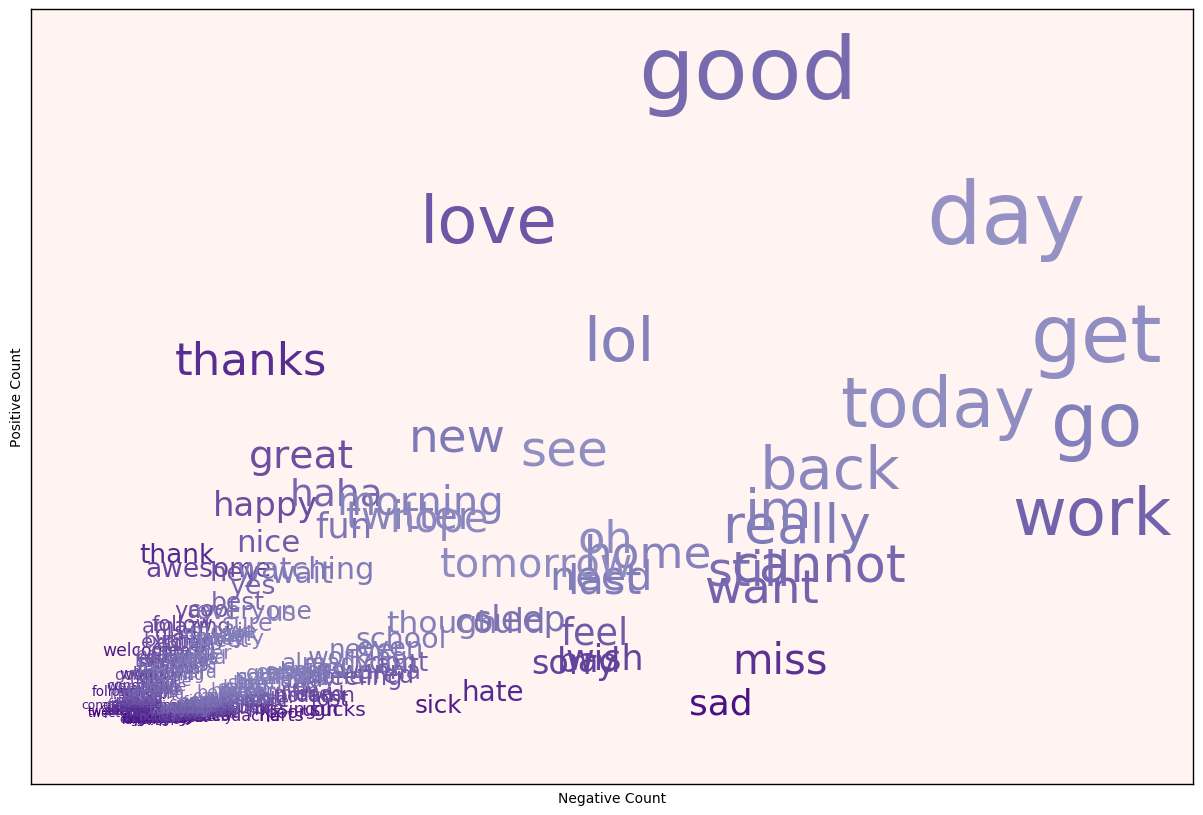

<function __main__.word_plot>

In [10]:
max_count = max(df['Count Difference'])
max_pos = max(df['Positive Count'])
max_neg = max(df['Negative Count'])

def text_size(total):
    """equals 8 if total is 0, 28 for most popular word"""
    return 8 + total / max_count * 20


cmap = plt.get_cmap('Purples') 
cNorm  = colors.Normalize(vmin=-1, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

def word_plot(words):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1)
    for index, row in df.head(words).iterrows():
        plt.text(row['Negative Count'], row['Positive Count'], row['Word'],
        ha='center', va='center', size = text_size(row['Total Count']), color=scalarMap.to_rgba(abs(row['Count Skew'])))
    plt.xlabel("Negative Count")
    plt.ylabel("Positive Count")
    plt.axis([max_neg*-.1, max_neg*1.1, max_pos*-.1, max_pos*1.1])
    ax.set_axis_bgcolor('#fff4f2')
    plt.xticks([])
    plt.yticks([])
    plt.show()

interact(word_plot,words=widgets.IntSlider(min=5,max=1000,step=5,value=300))

This graph illustrates how a machine learning algorithm might predict whether a word is positive or negative sentiment,
based on its position relative to the x=y axis. Similar to a wordcloud font size is proportional to total frequency, while
colour depth is proportional to degree of skew. It provides a sense check as words in the positive half are more positive words ("love", "thanks"),
and "sad" and "hate" are prominent in the negative half.

In [16]:
# Sample n from 160k tweets to reduce memory usage
data_train_sample = data_train.sample(1000)

# Split data into features and targets
text_train_all = data_train_sample['Text']
target_train_all = data_train_sample['Polarity'].values

# Split training csv into training and validation components
text_train_small, text_validation, target_train_small, target_validation = train_test_split(
    text_train_all, target_train_all, test_size=.2, random_state=42)

# Clean the training and validation features 
text_train_small = tweets_clean(text_train_small)
text_validation = tweets_clean(text_validation)

%xdel data_train_sample
%xdel text_train_all
%xdel target_train_all

Here data is prepared for machine learning. 

In [45]:
pipeline = Pipeline((
    ('vec', CountVectorizer(max_df=0.5,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    #('svd', TruncatedSVD(n_components=100)), 
    ('feature_selection', SelectFromModel(LinearSVC())),
    ('clf', LinearSVC())
))

pipeline.fit(text_train_small, target_train_small).score(text_validation, target_validation)

0.68500000000000005

Found logistic regression to be marginally better than SVM ('hinge') using grid search.
Best models found MultinomialNB and Logistic Regression (Maximum Entropy)
max_df: ignore terms that have a document frequency strictly higher 
than the given threshold.
ngram_range: generate unigrams and bigrams
use_idf=False: No inverse document frequency weighting, effectively just normalises

In [46]:
target_pred = pipeline.predict(text_validation)
print(classification_report(target_validation, target_pred, target_names=['negative','positive']))

             precision    recall  f1-score   support

   negative       0.63      0.72      0.67        90
   positive       0.74      0.65      0.70       110

avg / total       0.69      0.69      0.69       200

